In [1]:
import tensorflow as tf

In [2]:
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Flatten, Input, Concatenate, Dropout
from keras.applications.vgg16 import VGG16

In [3]:
img_input = Input(shape=(128, 128, 1))
img_conc = Concatenate()([img_input, img_input, img_input])    

In [4]:
# Creating Object of VGG16
convBase = VGG16(
    weights = 'imagenet',
    include_top = False,
    input_tensor=img_conc
)

In [5]:
# Unfreeze all The Layers
convBase.trainable = False

In [6]:
model = Sequential()
model.add(convBase)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(4, activation='softmax')) 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1024)              8389632   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 4)                 4

In [7]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [8]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_ds = image_dataset_from_directory(
    directory='hello1/hello1/Dataset',
    color_mode='grayscale',
    validation_split=0.2,
    subset='training',
    seed=123,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    interpolation='bilinear'
)

test_ds = image_dataset_from_directory(
    directory='hello1/hello1/Dataset',
    color_mode='grayscale',
    validation_split=0.2,
    subset='validation',
    seed=123,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(128, 128),
    shuffle=True,
    interpolation='bilinear'
)

# Normalize pixel values to [0, 1]
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

# Configure the datasets for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 11519 files belonging to 4 classes.
Using 9216 files for training.
Found 11519 files belonging to 4 classes.
Using 2303 files for validation.


In [9]:
hist = model.fit(train_ds, epochs = 50, validation_data = test_ds)

Epoch 1/50
288/288 [==============================] - 39s 95ms/step - loss: 0.9108 - accuracy: 0.6155 - val_loss: 0.6219 - val_accuracy: 0.7356
Epoch 2/50
288/288 [==============================] - 23s 80ms/step - loss: 0.5432 - accuracy: 0.7598 - val_loss: 0.5212 - val_accuracy: 0.7690
Epoch 3/50
288/288 [==============================] - 23s 80ms/step - loss: 0.4589 - accuracy: 0.7990 - val_loss: 0.4175 - val_accuracy: 0.8155
Epoch 4/50
288/288 [==============================] - 23s 80ms/step - loss: 0.4576 - accuracy: 0.8002 - val_loss: 0.4148 - val_accuracy: 0.8228
Epoch 5/50
288/288 [==============================] - 23s 80ms/step - loss: 0.4677 - accuracy: 0.7961 - val_loss: 0.4289 - val_accuracy: 0.8202
Epoch 6/50
288/288 [==============================] - 23s 80ms/step - loss: 0.4506 - accuracy: 0.7979 - val_loss: 0.4505 - val_accuracy: 0.8142
Epoch 7/50
288/288 [==============================] - 23s 81ms/step - loss: 0.4137 - accuracy: 0.8190 - val_loss: 0.3864 - val_accuracy:

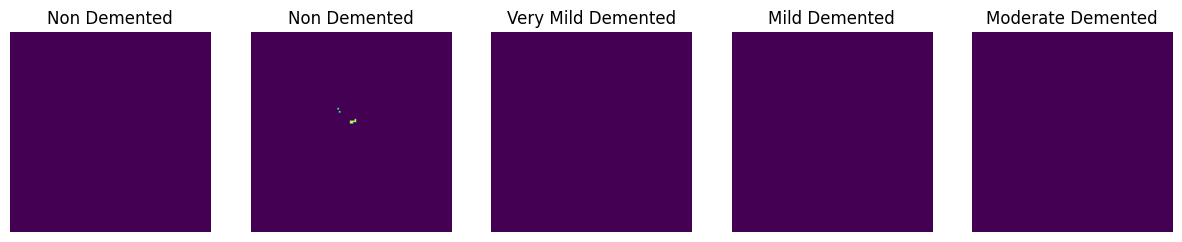

72/72 [==============================] - 5s 63ms/step


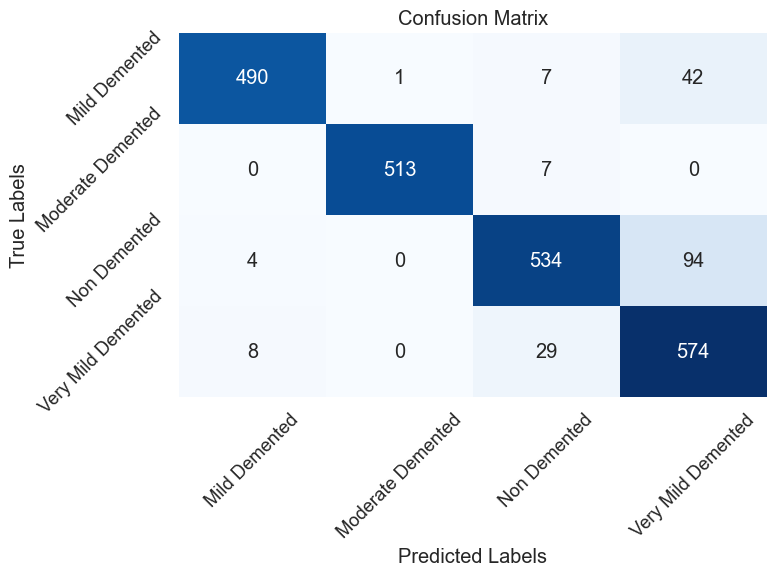

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Function to plot sample images from the dataset
def plot_sample_images(dataset, class_names, num_images=5):
    plt.figure(figsize=(15, 10))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
    plt.show()

# Plot sample images from the test dataset
plot_sample_images(test_ds, class_names=['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented'])

# Predict labels for the test dataset
predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)

# Extract true labels from the test dataset
true_labels = []
for images, labels in test_ds:
    true_labels.extend(labels.numpy())

true_labels = np.array(true_labels)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Compute classification report
class_report = classification_report(true_labels, predicted_labels)

# Plot confusion matrix
def plot_confusion_matrix(cm, class_names, save_path=None):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)
    sns.heatmap(cm, annot=True, cmap="Blues", fmt='g', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)  # Save the plot as an image
    plt.show()

plot_confusion_matrix(conf_matrix, class_names=['Mild Demented', 'Moderate Demented', 'Non Demented', 'Very Mild Demented'], save_path='confusion_matrixtl20VGG16.png')

# Save classification report to a text file
with open('classification_reporttl210VGG16.txt', 'w') as f:
    f.write(class_report)


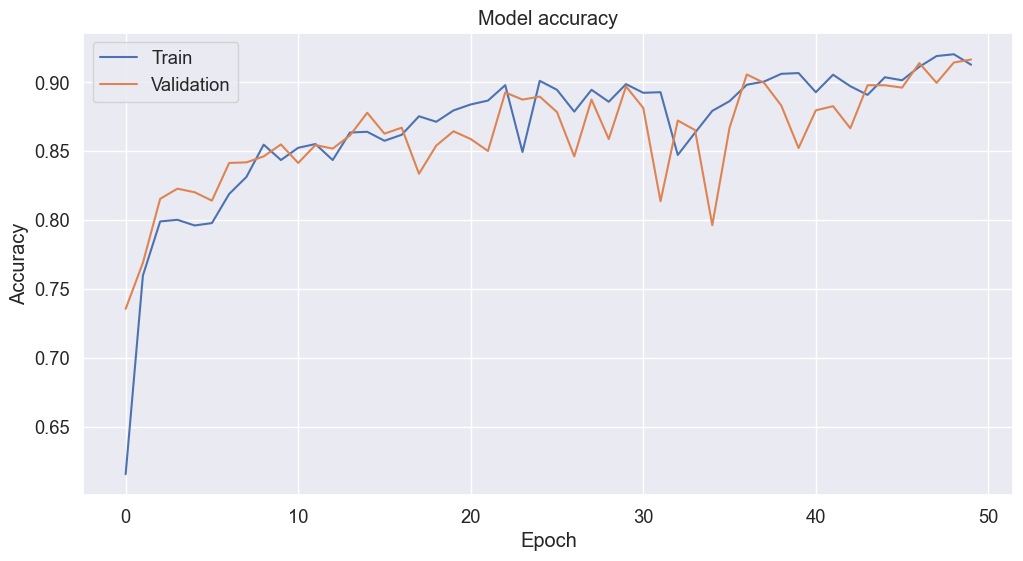

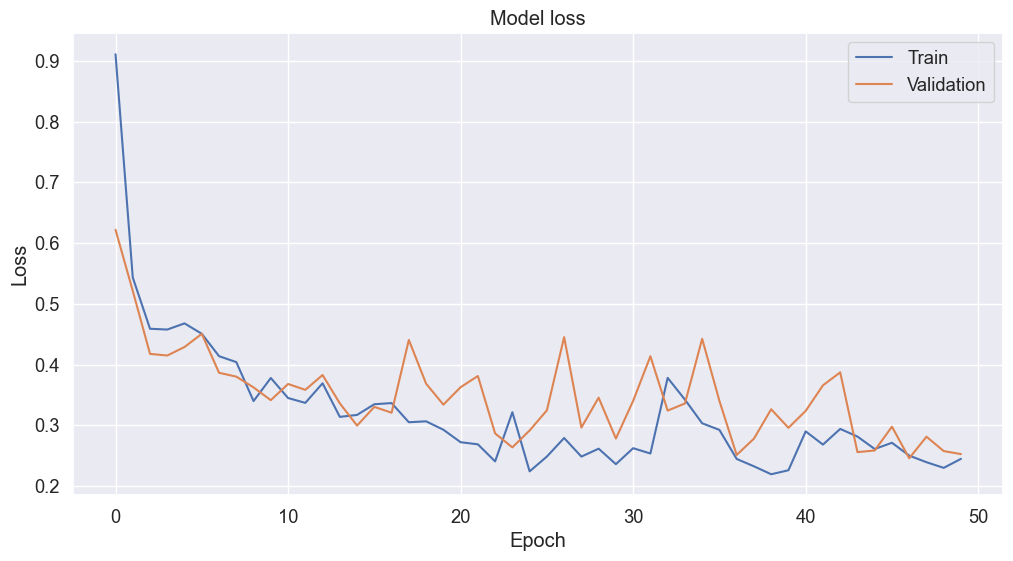

In [11]:
import matplotlib.pyplot as plt

def plot_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.grid(True)
    plt.savefig('Accuracytl20VGG16.png')
    plt.show()

    # Plot training & validation loss values
    plt.figure(figsize=(12, 6))
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.grid(True)
    plt.savefig('Losstl20VGG16.png')
    plt.show()

plot_history(hist)


72/72 [==============================] - 5s 63ms/step


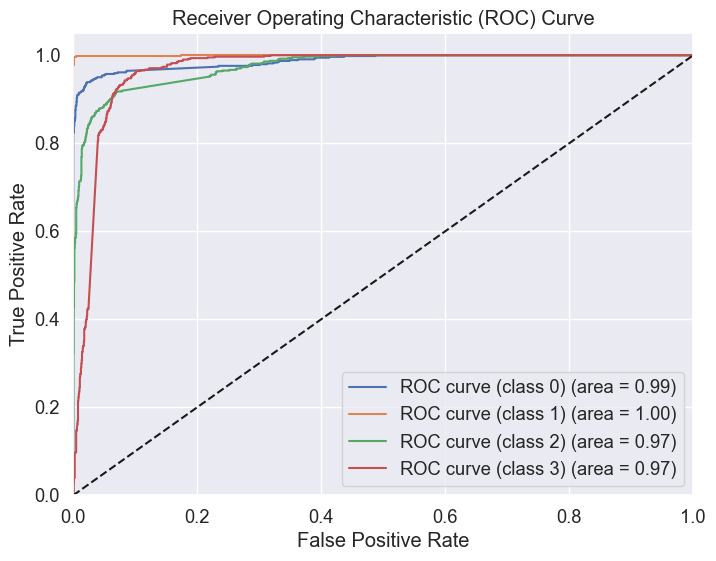

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
# Make predictions on the test data
y_pred_prob = model.predict(test_ds)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(4):
    plt.plot(fpr[i], tpr[i], label='ROC curve (class {}) (area = {:.2f})'.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Save the plot as an image file
plt.savefig('ROC_curvetl20VGG16.png')

# Show the plot
plt.show()
